# 一次元タスクでのRuLSIFとMCEWの比較

## 元データ生成
No Bias Left Behind: Covariate Shift Adaptation for Discriminative 3D Pose Estimationでのtoy practiceでの設定

In [175]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

In [176]:
def gen_x(y):
    return y + 0.3 * np.sin(2*np.pi*y) + np.random.normal(loc=0.0, scale=0.05, size=len(y))

In [177]:
np.random.seed(123)
# data size setting
data_size_train = 200
data_size_test = 400

# generate train /test data
test_y = np.concatenate((np.random.normal(0.9, scale=0.03, size=int(data_size_test/2)),
                         np.random.normal(0.1, scale=0.03, size=int(data_size_test/2))))
test_x = gen_x(test_y)

train_y = np.random.uniform(size=data_size_train)
train_x = gen_x(train_y)

Text(0,0.5,'y')

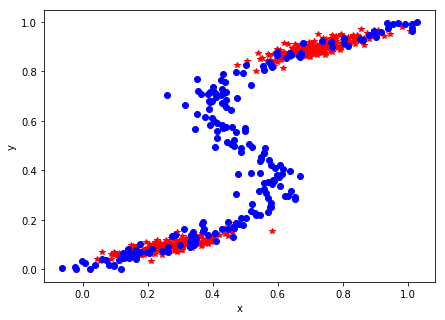

In [178]:
plt.figure(figsize=(7, 5))
plt.plot(test_x, test_y, 'r*', label='test')
plt.plot(train_x, train_y, 'bo', label='train')
plt.xlabel('x')
plt.ylabel('y')

(array([19., 58., 79., 35., 10., 25., 59., 79., 31.,  5.]),
 array([0.04454024, 0.14061836, 0.23669649, 0.33277461, 0.42885273,
        0.52493085, 0.62100897, 0.71708709, 0.81316522, 0.90924334,
        1.00532146]),
 <a list of 10 Patch objects>)

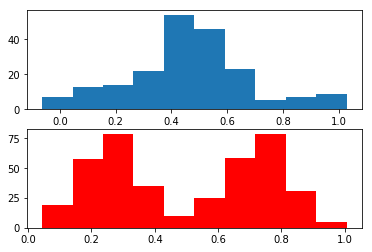

In [179]:
plt.subplot(2,1,1)
plt.hist(train_x)
plt.subplot(2,1,2)
plt.hist(test_x, color = 'r')

(array([176.,  24.,   0.,   0.,   0.,   0.,   0.,   0.,  58., 142.]),
 array([0.03245395, 0.12700347, 0.22155298, 0.3161025 , 0.41065202,
        0.50520153, 0.59975105, 0.69430057, 0.78885008, 0.8833996 ,
        0.97794912]),
 <a list of 10 Patch objects>)

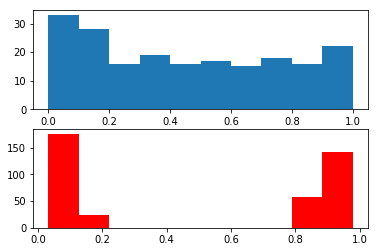

In [180]:
plt.subplot(2,1,1)
plt.hist(train_y)
plt.subplot(2,1,2)
plt.hist(test_y, color = 'r')

## 2 Kernel Logistic regressonの実装 

In [181]:
import numpy as np
from scipy.spatial import distance

In [182]:
sigma = 1
gamma = 0.2

***カーネル回帰モデル***

$f(x;A) = A^Tk(x)$

で表される。この時、
$k(x)=[1, K(x,x_1^{tr}), K(x,x_2^{tr}), \cdots K(x, x_{n_{tr}}^{tr})]^T$の場合、

モデルパラメータ$A$は、

$ \hat{A}= (\tilde{K}^{tr}W(\tilde{K}^{tr})^T+\gamma I)\tilde{K}^{tr}W(Y^{tr})^T $

で解析的に求まる。ここで、

$\tilde{K}^{tr}=[k(x_1^{tr}), k(x_2^{tr}), \cdots,k(x_{n_{tr}}^{tr})], Y^{tr}=[y_1^{tr}, \cdots, y_{n_{tr}}^{tr}]$である

### 学習

In [183]:
train = train_x[:, np.newaxis]
response = train_y
test = test_x[:, np.newaxis]

In [187]:
#W = np.diag(w[-train.T.shape[1]:])
W = np.eye(len(train))
K = np.concatenate((np.ones(len(train))[np.newaxis, :],
                np.exp(-distance.cdist(train, train)**2/2/sigma**2)))


_left = np.dot(np.dot(K, W), K.T) + gamma*np.eye(len(train)+1) 
_right = np.dot(np.dot(K, W), response.T)

A = np.dot(_left, _right)

In [174]:
A

array([3331454.86834347, 3248169.20249146, 3243369.01241238,
       3255428.48376753, 3129742.49790292, 3248191.14430274,
       3236347.11109839, 3256893.76262851, 3244366.44982005,
       3130496.68838858, 3032718.58714593, 3191472.51313519,
       3256631.86768938, 2905072.60251122, 3252927.49961024,
       3257100.70491143, 3194219.80524883, 3244932.90713571,
       3212201.18108547, 3246252.33732622, 3211466.65606601,
       3244052.04095028, 3101537.95401181, 3239700.60036816,
       2800357.3139269 , 3230381.10830154, 3243466.70869754,
       3099843.72650151, 3257242.26073203, 3243822.7922616 ,
       3256336.09830747, 3221410.91218226, 3011921.19594915,
       3085004.76733226, 3252850.2550698 , 3252122.01367305,
       3253045.40115321, 3248577.96535055, 3242385.3708592 ,
       3255631.93832483, 3202641.5177334 , 3072535.42960924,
       3230181.01962414, 3147955.18168519, 3231913.24655296,
       3252532.93233568, 2963924.31555336, 3244614.97739047,
       3233527.94332926,

### テスト

In [169]:
def pred_KR(test, train,A):
    basis = np.concatenate((np.ones(len(test))[np.newaxis, :],
                np.exp(-distance.cdist(train, test)**2/2/sigma**2)))
    y = np.dot(A, basis)
    return(y)

In [170]:
pred_KR(test, train, A)

array([6.06658861e+08, 5.97995691e+08, 6.06860129e+08, 6.23729449e+08,
       6.12351197e+08, 5.71083008e+08, 6.25932968e+08, 6.14972366e+08,
       5.88498751e+08, 6.09389753e+08, 6.10755584e+08, 6.05054470e+08,
       5.87353607e+08, 6.09708837e+08, 6.03712885e+08, 6.20116096e+08,
       5.62605908e+08, 5.73099829e+08, 5.97900303e+08, 6.17837995e+08,
       6.08121298e+08, 5.65570217e+08, 6.18774395e+08, 6.00274855e+08,
       6.19662995e+08, 6.17017941e+08, 5.93352192e+08, 6.10017572e+08,
       6.11937328e+08, 6.13802034e+08, 6.16214524e+08, 6.19118234e+08,
       6.19760110e+08, 6.19057869e+08, 5.85253159e+08, 5.98861452e+08,
       6.05183273e+08, 6.10449022e+08, 6.02508554e+08, 6.00522800e+08,
       6.06482026e+08, 6.22339679e+08, 6.13078247e+08, 5.98333761e+08,
       5.92521217e+08, 6.05494061e+08, 5.82192897e+08, 5.99216541e+08,
       5.76412504e+08, 5.70106042e+08, 6.17173110e+08, 6.21684595e+08,
       5.94729916e+08, 6.17618384e+08, 6.08476557e+08, 5.91017955e+08,
      

# RuLSIFでの重み付け
*Relative unconstrained least-squares importance fitting*の略。重みをカーネル関数の足し合わせ(係数未知)として、この係数を真の相対重要度（密度比）との２乗誤差を最小化するという学習基準に基づいて学習する。二乗誤差を学習基準にすることで、ロバストな重み付が学習できるそう(杉山先生の資料(2013)より)

実装は[こちら](http://allmodelsarewrong.org/RuLSIF.html)を拝借している

密度比推定の論文は、求めているものは密度比$\frac{p_{test}(x)}{p_{train}(x)}$になるので, entropy estimatorでの重みの総和1制約のようなものは存在しない

### コードの追試（１次元での密度比推定）

In [8]:
from pyRULSIF import *
from pylab import *

In [15]:
# x_nu: samples from numerator(test data)
# x_de: samples from denominator(train data)
# x_re: reference sample
# alpha: alpha defined in relative density ratio
# sigma_list, lambda_list: parameters for model selection
# b: number of kernel basis
# fold: number of fold for cross validation

In [9]:
np.random.seed(1)
# generate data.
x_nu = randn(1, 50)*.25 - 1
x_de = randn(1, 100)*.5
x_re = array([arange(-1.5, 1.5, .05)])

In [10]:
# using normal ULSIF, which is RULSIF with alpha = 0.
alpha = 0
PE, w, s = R_ULSIF(x_nu, x_de, c_[x_re, x_nu, x_de], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

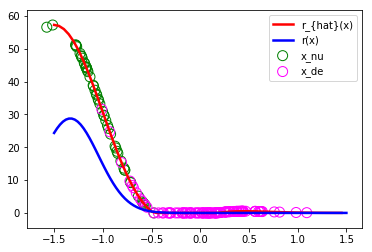

alpha =  0
divergence =  19.84959541447472


In [11]:
# plotting with true density ratio
w_re = w[0:x_re.shape[1]]
plot(x_re.T, w_re, label='r_{hat}(x)', linewidth=2.5, color='red')
w_nu = w[x_re.shape[1]:x_re.shape[1]+x_nu.shape[1]]
scatter(x_nu, w_nu, label='x_nu', color='green', facecolors='none', s=100)
w_de = w[x_re.shape[1]+x_nu.shape[1]:]
scatter(x_de, w_de, label='x_de', color='magenta', facecolors='none', s=100)

x_disp = linspace(-1.5, 1.5, 100)
plot(x_disp, norm_pdf(x_disp, -1, .25)/norm_pdf(x_disp, 0, .5),
     linewidth=2.5, label='r(x)', color='blue')
legend()
show()

print('alpha = ', alpha)
print('divergence = ', PE)

### 2次元以上でもRuLSIFがworkするか確認

In [12]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 300)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

In [13]:
x_re_2d = np.concatenate((np.linspace(-4,4,500)[:,np.newaxis], np.linspace(-4,4,500)[:,np.newaxis]), axis = 1)

In [14]:
PE, w, s = R_ULSIF(y.T, x.T, c_[x_re_2d.T, y.T, x.T], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

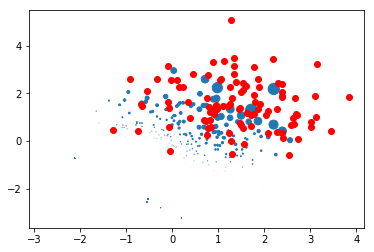

In [15]:
plt.scatter(x[:,0], x[:,1],  s = w[600:900]*10)
plt.plot(y[:,0], y[:,1], 'ro')

いけますた